In [1]:
import numpy as np
import sys
import h5py
import platform
import matplotlib
import matplotlib.pyplot as plot
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

node_name = platform.node()

LOCAL_NODE = 'DESKTOP-L3FA8HC'
if node_name==LOCAL_NODE:
    import matplotlib.pyplot as plot
    import matplotlib.colors as mplcolors
    useGPU=False    
    HOMEDIR = 'F:/projects/pinns_narval/sync/'
    sys.path.append('F:/projects/pinns_local/code/')

from pinns_data_assimilation.lib.file_util import create_directory_if_not_exists
from pinns_data_assimilation.lib.dft import dft

# read the data

base_dir = HOMEDIR+'data/mazi_fixed_grid/'
time_data_dir = 'F:/projects/fixed_cylinder/grid/data/'
assimilated_data_dir = 'F:/projects/paper_figures/t010_f2/data/'
figures_dir = 'F:/projects/paper_figures/t010_f2/thesis/galerkin/'

meanVelocityFile = h5py.File(base_dir+'meanVelocity.mat','r')
meanPressureFile = h5py.File(base_dir+'meanPressure.mat','r')
configFile = h5py.File(base_dir+'configuration.mat','r')
fluctuatingVelocityFile = h5py.File(base_dir+'fluctuatingVelocity.mat','r')
fluctuatingPressureFile = h5py.File(base_dir+'fluctuatingPressure.mat','r')

fs = 10.0

x = np.array(configFile['X_vec'][0,:])
X_grid = np.array(configFile['X_grid'])
y = np.array(configFile['X_vec'][1,:])
Y_grid = np.array(configFile['Y_grid'])
d = np.array(configFile['cylinderDiameter'])

ux = np.array(meanVelocityFile['meanVelocity'][0,:]).transpose()
uy = np.array(meanVelocityFile['meanVelocity'][1,:]).transpose()
p = np.array(meanPressureFile['meanPressure']).transpose()

L_dft=4082
fs = 10.0
t = np.arange(0,L_dft)/fs
nu_mol = 1/150.0


ux_ref = np.array(fluctuatingVelocityFile['fluctuatingVelocity'][0,:,:]).transpose()
uy_ref = np.array(fluctuatingVelocityFile['fluctuatingVelocity'][1,:,:]).transpose()
p_ref = np.array(fluctuatingPressureFile['fluctuatingPressure']).transpose()
p_ref = p_ref + np.reshape(p,[p_ref.shape[0],1])
ux_ref = ux_ref[:,0:L_dft]
uy_ref = uy_ref[:,0:L_dft]
p_ref = p_ref[:,0:L_dft]




# load the POD and POD downsampled sets

n_LOM = 12 # number of POD modes saved

from pinns_data_assimilation.lib.downsample import compute_downsample_inds_center
from pinns_data_assimilation.lib.decomposition import POD
from pinns_data_assimilation.lib import galerkin

In [5]:
class POD_obj():
    def __init__(self):
        pass

POD_ds = [] # POD of downsampled field
POD_as = [] # downsample of true POD
S_star = [1,2,4,8,16,32] # ,8,16,32
for S in S_star:
    POD_ds.append(POD_obj())
    POD_as.append(POD_obj())
    
dx = []

n_Pairs = int(n_LOM/2.0)









In [6]:
# phase angle between the downsampled mode and reference, optimized in loop
theta_ds = np.zeros((len(S_star),n_Pairs))

# phase angles between different mode pairs; generally this is pi/2 but some modes get interchanged so it may be -pi/2
theta_m_ds = (np.pi/2)*np.ones((len(S_star),n_Pairs))
theta_m_ds[3,3] = -np.pi/2
theta_m_ds[2,5] = -np.pi/2
if True:
    for iS in range(len(S_star)):
        # compute the downsampled mean velocity fields, needed as Phi[0]
        S_i = S_star[iS]
        if S_i>1:
            linear_downsample_inds, ndx,ndy = compute_downsample_inds_center(S_i,X_grid[:,0],Y_grid[0,:].transpose())
            linear_downsample_inds = (np.reshape(linear_downsample_inds,(ndy,ndx)).transpose()).ravel()
            temp_ux = ux[linear_downsample_inds]
            temp_uy = uy[linear_downsample_inds]
            temp_ux_grid = np.reshape(ux[linear_downsample_inds],(ndx,ndy))
            temp_uy_grid = np.reshape(uy[linear_downsample_inds],(ndx,ndy))
            

            # downsample the unsteady field
            ux_ref_ds = ux_ref[linear_downsample_inds,:]
            uy_ref_ds = uy_ref[linear_downsample_inds,:]
            p_ref_ds = p_ref[linear_downsample_inds,:]
            X_grid_ds = np.reshape((X_grid.ravel())[linear_downsample_inds],(ndx,ndy))
            Y_grid_ds = np.reshape((Y_grid.ravel())[linear_downsample_inds],(ndx,ndy))
        else:
            ndx = X_grid.shape[0]
            ndy = X_grid.shape[1]
            temp_ux = np.copy(ux)
            temp_uy = np.copy(uy)
            temp_ux_grid = np.reshape(ux,X_grid.shape)
            temp_uy_grid = np.reshape(uy,X_grid.shape)
            ux_ref_ds = np.copy(ux_ref)
            uy_ref_ds = np.copy(uy_ref)
            p_ref_ds = np.copy(p_ref)
            X_grid_ds = np.copy(X_grid)
            Y_grid_ds = np.copy(Y_grid)
            x_ds = np.copy(x)

        # cylinder mask
        cylinder_mask = (np.power(np.power(X_grid_ds,2)+np.power(Y_grid_ds,2),0.5)<(0.5*d))
        dx.append(X_grid_ds[1,0]-X_grid_ds[0,0])



        # compute the POD of the downsampled field
        U_pod = np.concatenate((ux_ref_ds,uy_ref_ds),axis=0)

        Phi, Lambda, Ak = POD(U_pod)

        Phi = Phi[:,0:n_LOM]
        Ak = Ak[:,0:n_LOM] 


        # create the custom phi matrix, per the notation of Noack ISSM slides
        # linear version
        POD_ds[iS].Phi_x = np.zeros([temp_ux.shape[0],n_LOM+1])
        POD_ds[iS].Phi_y = np.zeros([temp_uy.shape[0],n_LOM+1])
        POD_ds[iS].Phi_x[:,0] = temp_ux
        POD_ds[iS].Phi_y[:,0] = temp_uy
        POD_ds[iS].Phi_x[:,1:(n_LOM+1)] = Phi[0:(temp_ux_grid.size),:]
        POD_ds[iS].Phi_y[:,1:(n_LOM+1)] = Phi[(temp_ux_grid.size):2*(temp_ux_grid.size),:]
        # grid version
        POD_ds[iS].Phi_x_grid = np.zeros([temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM+1])
        POD_ds[iS].Phi_y_grid = np.zeros([temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM+1])
        POD_ds[iS].Phi_x_grid[:,:,0] = temp_ux_grid
        POD_ds[iS].Phi_y_grid[:,:,0] = temp_uy_grid
        POD_ds[iS].Phi_x_grid[:,:,1:(n_LOM+1)] = np.reshape(Phi[0:(temp_ux_grid.size),:],[temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM])
        POD_ds[iS].Phi_y_grid[:,:,1:(n_LOM+1)] = np.reshape(Phi[(temp_ux_grid.size):2*(temp_ux_grid.size),:],[temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM])

        # create the custom Ak matrix per notation of noack that includes a ones vector along the mean
        Ak_temp = np.ones([Ak.shape[0],Ak.shape[1]+1])
        Ak_temp[:,1:Ak.shape[1]+1] = Ak

        POD_ds[iS].Ak = Ak_temp              

        # compute the reference area of the POD
        POD_ds[iS].X_grid = X_grid_ds
        POD_ds[iS].Y_grid = Y_grid_ds
        grad_X_grid = np.gradient(POD_ds[iS].X_grid,axis=0)
        grad_Y_grid = np.gradient(POD_ds[iS].Y_grid,axis=1)
        A0 = np.sum((grad_X_grid.ravel())*(grad_Y_grid.ravel()),axis=0)
        M0 = POD_ds[0].X_grid.shape[0]*POD_ds[0].X_grid.shape[1]
        Mi = POD_ds[iS].X_grid.shape[0]*POD_ds[iS].X_grid.shape[1]

        
        # do the galerkin projection for the POD of the downsampled velocity
        # note that we dont need to reuse these gradients, so we don't assign them to the object
        # send quantities to (nx,ny) grid
        p_t_grid = np.reshape(p_ref_ds,np.array([POD_ds[iS].X_grid.shape[0],POD_ds[iS].X_grid.shape[1],p_ref_ds.shape[1]]))

        # compute derivatives
        phi_x_x_grid = np.gradient(POD_ds[iS].Phi_x_grid,POD_ds[iS].X_grid[:,0],axis=0)
        phi_x_xx_grid = np.gradient(phi_x_x_grid,POD_ds[iS].X_grid[:,0],axis=0)
        phi_x_y_grid = np.gradient(POD_ds[iS].Phi_x_grid,POD_ds[iS].Y_grid[0,:],axis=1)
        phi_x_yy_grid = np.gradient(phi_x_y_grid,POD_ds[iS].Y_grid[0,:],axis=1)

        phi_y_x_grid = np.gradient(POD_ds[iS].Phi_y_grid,POD_ds[iS].X_grid[:,0],axis=0)
        phi_y_xx_grid = np.gradient(phi_y_x_grid,POD_ds[iS].X_grid[:,0],axis=0)
        phi_y_y_grid = np.gradient(POD_ds[iS].Phi_y_grid,POD_ds[iS].Y_grid[0,:],axis=1)
        phi_y_yy_grid = np.gradient(phi_y_y_grid,POD_ds[iS].Y_grid[0,:],axis=1)

        p_t_x_grid = np.gradient(p_t_grid,POD_ds[iS].X_grid[:,0],axis=0)
        p_t_y_grid = np.gradient(p_t_grid,POD_ds[iS].Y_grid[0,:],axis=1)


        # set elements in cylinder to zero
        phi_x_x_grid[cylinder_mask]=0
        phi_x_xx_grid[cylinder_mask]=0
        phi_y_x_grid[cylinder_mask]=0
        phi_y_xx_grid[cylinder_mask]=0
        phi_x_y_grid[cylinder_mask]=0
        phi_x_yy_grid[cylinder_mask]=0
        phi_y_y_grid[cylinder_mask]=0
        phi_y_yy_grid[cylinder_mask]=0


        # send derivatives to (nx*ny) vector
        phi_x_x = np.reshape(phi_x_x_grid,POD_ds[iS].Phi_x_grid.shape)
        phi_x_y = np.reshape(phi_x_x_grid,POD_ds[iS].Phi_x_grid.shape)
        phi_x_xx = np.reshape(phi_x_xx_grid,POD_ds[iS].Phi_x_grid.shape)
        phi_x_yy = np.reshape(phi_x_yy_grid,POD_ds[iS].Phi_x_grid.shape)

        phi_y_x = np.reshape(phi_y_x_grid,POD_ds[iS].Phi_x_grid.shape)

        phi_y_y = np.reshape(phi_y_y_grid,POD_ds[iS].Phi_x_grid.shape)
        phi_y_xx = np.reshape(phi_y_xx_grid,POD_ds[iS].Phi_x_grid.shape)
        phi_y_yy = np.reshape(phi_y_yy_grid,POD_ds[iS].Phi_x_grid.shape)

        p_t_x = np.reshape(p_t_x_grid,p_ref_ds.shape)
        p_t_y = np.reshape(p_t_y_grid,p_ref_ds.shape)

        dX = np.gradient(POD_ds[iS].X_grid,axis=0)
        dY = np.gradient(POD_ds[iS].Y_grid,axis=1)

        dA = dX*dY # we need to normalize this by the A of the S=1 case so that we get back the right magnitude of TC's

        # compute galerkin projection
        D_ij, C_ijk = galerkin.galerkin_noack(POD_ds[iS].Phi_x_grid,phi_x_x_grid,phi_x_y_grid,phi_x_xx_grid,phi_x_yy_grid,POD_ds[iS].Phi_y_grid,phi_y_x_grid,phi_y_y_grid,phi_y_xx_grid,phi_y_yy_grid)

        i_Dij = np.zeros([D_ij.shape[2],D_ij.shape[3]])
        i_Cijk = np.zeros([C_ijk.shape[2],C_ijk.shape[3],C_ijk.shape[4]])
        
        # integrate the interactions
        # trapezoidal integration
        for i in range(D_ij.shape[2]):
            for j in range(D_ij.shape[3]):
                i_Dij_x = np.trapz(D_ij[:,:,i,j],POD_ds[iS].X_grid[:,0],axis=0) # integrate in x-direction, collapses first dimension
                i_Dij[i,j] = (Mi/A0)*np.trapz(i_Dij_x,POD_ds[iS].Y_grid[0,:],axis=0)  # integrate in y-direction; note that the first dimension of above is y
                for k in range(C_ijk.shape[4]):
                    i_Cijk_x = np.trapz(C_ijk[:,:,i,j,k],POD_ds[iS].X_grid[:,0],axis=0) # integrate in x-direction, collapses first dimension
                    i_Cijk[i,j,k] = (Mi/A0)*np.trapz(i_Cijk_x,POD_ds[iS].Y_grid[0,:],axis=0)# integrate in y-direction; note that the first dimension of above is y
        
        POD_ds[iS].i_Dij = i_Dij
        POD_ds[iS].i_Cijk = i_Cijk    

        # calibrate the pressure using linear regression
        n_LOM_p = n_LOM+1
        Phi_p_t_k = np.zeros([n_LOM_p,p_ref_ds.shape[1]])
        L_pi_kl = np.zeros([n_LOM_p,n_LOM_p])

        ## compute the inner product of the pressure gradient with the velocity modes, notice here we use the vector version of phi 
        for k in range(n_LOM_p):
            Phi_p_t_k[k,:] = np.sum((-np.reshape(POD_ds[iS].Phi_x[:,k],[POD_ds[iS].Phi_x.shape[0],1])*p_t_x-np.reshape(POD_ds[iS].Phi_y[:,k],[POD_ds[iS].Phi_y.shape[0],1])*p_t_y),axis=0)
        amp_Phi_p_t_k = 0.5*np.max(Phi_p_t_k,axis=0)-0.5*np.min(Phi_p_t_k,axis=0)

        ## compute the linear coefficients based on the inverse of the temporal coefficients and the pressure contribution
        Ak_inv = np.linalg.pinv(POD_ds[iS].Ak[:,0:n_LOM_p]).transpose()
        for k in range(n_LOM_p):
            L_pi_kl[k,:]=np.matmul(np.reshape(Phi_p_t_k[k,:],[1,Phi_p_t_k.shape[1]]),Ak_inv)
        POD_ds[iS].L_pi_kl = L_pi_kl

        # test if the linear coefficients accurately reconstruct the pressure contribution
        Phi_p_t_r = np.zeros(Phi_p_t_k.shape)
        for k in range(n_LOM):
            Phi_p_t_r[k,:] = np.matmul(L_pi_kl[k,:],POD_ds[iS].Ak[:,0:n_LOM_p].transpose())

        # validation using derivtive comparison
        # compute the derivative using the galerkin equations
        dAk_g = np.zeros([POD_ds[iS].Ak.shape[0],n_LOM+1])

        # use the downsampled mode's TCs
        for k in range(n_LOM+1):
             for l in range(n_LOM+1):
                dAk_g[:,k] = dAk_g[:,k]+ (nu_mol*i_Dij[k,l]*POD_ds[iS].Ak[:,l]+L_pi_kl[k,l]*POD_ds[iS].Ak[:,l])
                for m in range(n_LOM+1):
                    dAk_g[:,k] = dAk_g[:,k]+(-i_Cijk[k,l,m]*POD_ds[iS].Ak[:,l]*POD_ds[iS].Ak[:,m])
        # scale because the TC's energy depends on number of cells
        dAk_g = np.sqrt(M0/Mi)*dAk_g
        POD_ds[iS].dAk_g = dAk_g # save the original derivatives
        
        # compute the phase offsets of the assimilated derivative
        if iS==0:
            dAk_g_rot = dAk_g # no rotation
            POD_ds[iS].dAk_g_rot = dAk_g_rot
        else:
            from scipy.optimize import minimize
            if True:
                for p_i in range(n_Pairs):
                    # note there is an offset of +1 here due to the first mode being a constant
                    fun=lambda theta: np.sum(np.power((np.cos(theta)*dAk_g[:,2*p_i+1]+np.sin(theta)*dAk_g[:,2*p_i+1+1])-POD_ds[0].dAk_g[:,2*p_i+1],2.0)+np.power((np.cos(theta+theta_m_ds[iS,p_i])*dAk_g[:,2*p_i+1]+np.sin(theta+theta_m_ds[iS,p_i])*dAk_g[:,2*p_i+1+1])-POD_ds[0].dAk_g[:,2*p_i+1+1],2.0),axis=0)
                    opt_result = minimize(fun,0.0,tol=1E-14)
                    theta_ds[iS,p_i]= opt_result.x[0]

            dAk_g_rot = np.zeros(dAk_g.shape)
            dAk_g_rot[:,0]=dAk_g[:,0] # constant mode
            for p_i in range(n_Pairs):
                dAk_g_rot[:,2*p_i+1] = (np.cos(theta_ds[iS,p_i])*dAk_g[:,2*p_i+1]+np.sin(theta_ds[iS,p_i])*dAk_g[:,2*p_i+1+1])
                dAk_g_rot[:,2*p_i+1+1] = (np.cos(theta_ds[iS,p_i]+theta_m_ds[iS,p_i])*dAk_g[:,2*p_i+1]+np.sin(theta_ds[iS,p_i]+theta_m_ds[iS,p_i])*dAk_g[:,2*p_i+1+1])
            POD_ds[iS].dAk_g_rot = dAk_g_rot

        amp_dAk_0 = np.zeros((POD_ds[0].dAk_g.shape[1],)) # rms of dAk_0
        amp_dAk_0[0]=1 # we need to set the amplitude of the constant term to not zero
        inds1 = np.arange(1,POD_ds[0].dAk_g.shape[1]-1,2)
        amp_dAk_0[inds1]=np.sqrt(np.mean(np.power(POD_ds[0].dAk_g[:,inds1],2.0)+np.power(POD_ds[0].dAk_g[:,inds1+1],2.0),axis=0))
        amp_dAk_0[inds1+1]=amp_dAk_0[inds1]
        
        err_dAk =  np.sqrt(np.mean(np.power(dAk_g_rot-POD_ds[0].dAk_g,2.0),axis=0))/amp_dAk_0 # should be 1 x n_LOM

        POD_ds[iS].err_dAk = err_dAk  

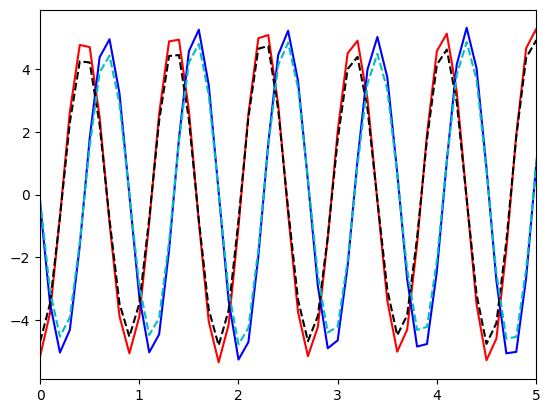

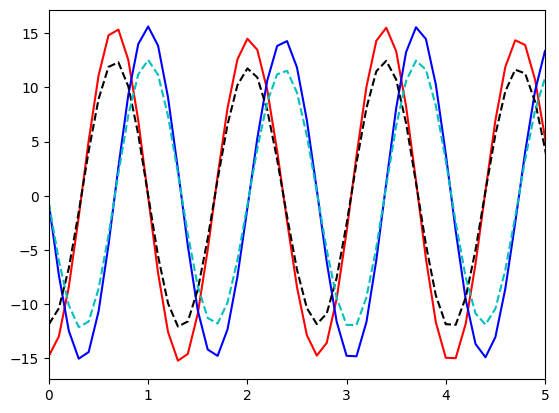

In [7]:
# there are two cases with issues using the default values of the optimization
plot.figure(1)
plot.plot(t,POD_ds[0].dAk_g[:,11],'r')
plot.plot(t,POD_ds[0].dAk_g[:,12],'b')
plot.plot(t,POD_ds[2].dAk_g_rot[:,11],'--k')
plot.plot(t,POD_ds[2].dAk_g_rot[:,12],'--c')
plot.xlim([0,5])
plot.show()
          
plot.figure(1)
plot.plot(t,POD_ds[0].dAk_g[:,7],'r')
plot.plot(t,POD_ds[0].dAk_g[:,8],'b')
plot.plot(t,POD_ds[3].dAk_g_rot[:,7],'--k')
plot.plot(t,POD_ds[3].dAk_g_rot[:,8],'--c')
plot.xlim([0,5])
plot.show()

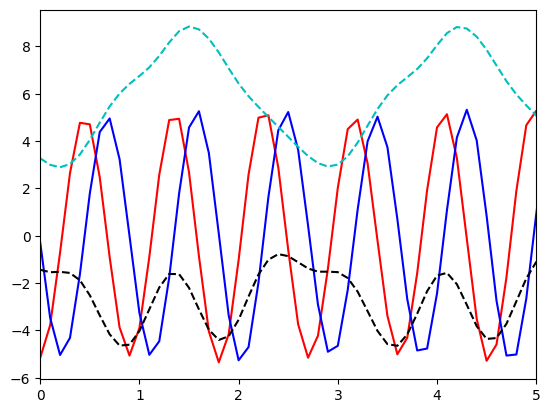

In [39]:

plot.figure(1)
plot.plot(t,POD_ds[0].dAk_g[:,11],'r')
plot.plot(t,POD_ds[0].dAk_g[:,12],'b')
plot.plot(t,POD_ds[5].dAk_g_rot[:,11],'--k')
plot.plot(t,POD_ds[5].dAk_g_rot[:,12],'--c')
plot.xlim([0,5])
plot.show()

In [ ]:
# modes with wrong phase shifts
# 4,7
# 5,7
# 0:3,9
# 0:5,11


theta_m_as = (np.pi/2)*np.ones((len(S_star),n_Pairs))
theta_m_as[4,3] = -np.pi/2
theta_m_as[5,3] = -np.pi/2
theta_m_as[0:4,4] = -np.pi/2
theta_m_as[0:6,5] = -np.pi/2

theta_as = np.zeros((len(S_star),n_Pairs))

if True:
    # now do the assimilated fields
    for iS in range(len(S_star)):
        S_i = S_star[iS]
        # first load the asimialted velocity
        if S_i>1:
            assimilatedFile =  h5py.File(assimilated_data_dir+'rec_pinn_S'+str(S_i)+'_c5.h5','r')
        else:
            assimilatedFile =  h5py.File(assimilated_data_dir+'rec_pinn_S0_c5.h5','r')
        ux_rec = np.array(assimilatedFile['ux']) # should be the unsteady velocity, it includes the mean field
        uy_rec = np.array(assimilatedFile['uy'])
        p_rec = np.array(assimilatedFile['p'])

        # cylinder mask
        cylinder_mask = (np.power(np.power(X_grid,2)+np.power(Y_grid,2),0.5)<(0.5*d))
        
        ux_rec_mean = np.mean(ux_rec,axis=1) # comput the mean
        uy_rec_mean = np.mean(uy_rec,axis=1)
        # compute the temp quantities
        temp_ux = ux_rec_mean
        temp_uy = uy_rec_mean
        temp_ux_grid = np.reshape(ux_rec_mean,X_grid.shape)
        temp_uy_grid = np.reshape(uy_rec_mean,X_grid.shape)


        ux_rec = ux_rec - np.reshape(ux_rec_mean,[ux_rec_mean.shape[0],1])
        uy_rec = uy_rec - np.reshape(uy_rec_mean,[ux_rec_mean.shape[0],1])
        # we dont need to compute the fluctuating pressure because we calibrate using linear regression
        ux_rec[cylinder_mask.ravel(),:] = 0.0
        uy_rec[cylinder_mask.ravel(),:] = 0.0
    
        #plot.figure(1)
        #plot.contourf(X_grid,Y_grid,np.reshape(ux_rec[:,0],X_grid.shape))
        #plot.colorbar()
        #plot.set_cmap('bwr')
        #plot.show()
    

        # compute the POD of the downsampled field
        U_pod = np.concatenate((ux_rec,uy_rec),axis=0)

        Phi, Lambda, Ak = POD(U_pod)

        Phi = Phi[:,0:n_LOM]
        Ak = Ak[:,0:n_LOM]

        # create the custom phi matrix, per the notation of Noack ISSM slides
        # linear version
        POD_as[iS].Phi_x = np.zeros([temp_ux.shape[0],n_LOM+1])
        POD_as[iS].Phi_y = np.zeros([temp_uy.shape[0],n_LOM+1])
        POD_as[iS].Phi_x[:,0] = temp_ux
        POD_as[iS].Phi_y[:,0] = temp_uy
        POD_as[iS].Phi_x[:,1:(n_LOM+1)] = Phi[0:(temp_ux_grid.size),:]
        POD_as[iS].Phi_y[:,1:(n_LOM+1)] = Phi[(temp_ux_grid.size):2*(temp_ux_grid.size),:]
        # grid version
        POD_as[iS].Phi_x_grid = np.zeros([temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM+1])
        POD_as[iS].Phi_y_grid = np.zeros([temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM+1])
        POD_as[iS].Phi_x_grid[:,:,0] = temp_ux_grid
        POD_as[iS].Phi_y_grid[:,:,0] = temp_uy_grid
        POD_as[iS].Phi_x_grid[:,:,1:(n_LOM+1)] = np.reshape(Phi[0:(temp_ux_grid.size),:],[temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM])
        POD_as[iS].Phi_y_grid[:,:,1:(n_LOM+1)] = np.reshape(Phi[(temp_ux_grid.size):2*(temp_ux_grid.size),:],[temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM])

        # create the custom Ak matrix per notation of noack that includes a ones vector along the mean
        Ak_temp = np.ones([Ak.shape[0],Ak.shape[1]+1])
        Ak_temp[:,1:Ak.shape[1]+1] = Ak

        POD_as[iS].Ak = Ak_temp
        POD_as[iS].X_grid = X_grid
        POD_as[iS].Y_grid = Y_grid

        
        grad_X_grid = np.gradient(POD_as[iS].X_grid,axis=0)
        grad_Y_grid = np.gradient(POD_as[iS].Y_grid,axis=1)

        # compute the reference area of the POD
        A0 = np.sum((grad_X_grid.ravel())*(grad_Y_grid.ravel()),axis=0)
        Mi = POD_as[iS].X_grid.shape[0]*POD_as[iS].X_grid.shape[1]
        
        # do the galerkin projection for the POD of the downsampled velocity
        # note that we dont need to reuse these gradients, so we don't assign them to the object

        # send quantities to (nx,ny) grid
        p_t_grid = np.reshape(p_rec,np.array([POD_as[iS].X_grid.shape[0],POD_as[iS].X_grid.shape[1],p_ref_ds.shape[1]]))

        # compute derivatives
        phi_x_x_grid = np.gradient(POD_as[iS].Phi_x_grid,POD_as[iS].X_grid[:,0],axis=0)
        phi_x_xx_grid = np.gradient(phi_x_x_grid,POD_as[iS].X_grid[:,0],axis=0)
        phi_x_y_grid = np.gradient(POD_as[iS].Phi_x_grid,POD_as[iS].Y_grid[0,:],axis=1)
        phi_x_yy_grid = np.gradient(phi_x_y_grid,POD_as[iS].Y_grid[0,:],axis=1)

        phi_y_x_grid = np.gradient(POD_as[iS].Phi_y_grid,POD_as[iS].X_grid[:,0],axis=0)
        phi_y_xx_grid = np.gradient(phi_y_x_grid,POD_as[iS].X_grid[:,0],axis=0)
        phi_y_y_grid = np.gradient(POD_as[iS].Phi_y_grid,POD_as[iS].Y_grid[0,:],axis=1)
        phi_y_yy_grid = np.gradient(phi_y_y_grid,POD_as[iS].Y_grid[0,:],axis=1)

        p_t_x_grid = np.gradient(p_t_grid,POD_as[iS].X_grid[:,0],axis=0)
        p_t_y_grid = np.gradient(p_t_grid,POD_as[iS].Y_grid[0,:],axis=1)


        # set elements in cylinder to zero
        phi_x_x_grid[cylinder_mask]=0
        phi_x_xx_grid[cylinder_mask]=0
        phi_y_x_grid[cylinder_mask]=0
        phi_y_xx_grid[cylinder_mask]=0
        phi_x_y_grid[cylinder_mask]=0
        phi_x_yy_grid[cylinder_mask]=0
        phi_y_y_grid[cylinder_mask]=0
        phi_y_yy_grid[cylinder_mask]=0


        # send derivatives to (nx*ny) vector
        phi_x_x = np.reshape(phi_x_x_grid,POD_as[iS].Phi_x_grid.shape)
        phi_x_y = np.reshape(phi_x_x_grid,POD_as[iS].Phi_x_grid.shape)
        phi_x_xx = np.reshape(phi_x_xx_grid,POD_as[iS].Phi_x_grid.shape)
        phi_x_yy = np.reshape(phi_x_yy_grid,POD_as[iS].Phi_x_grid.shape)

        phi_y_x = np.reshape(phi_y_x_grid,POD_as[iS].Phi_x_grid.shape)

        phi_y_y = np.reshape(phi_y_y_grid,POD_as[iS].Phi_x_grid.shape)
        phi_y_xx = np.reshape(phi_y_xx_grid,POD_as[iS].Phi_x_grid.shape)
        phi_y_yy = np.reshape(phi_y_yy_grid,POD_as[iS].Phi_x_grid.shape)

        p_t_x = np.reshape(p_t_x_grid,p_rec.shape)
        p_t_y = np.reshape(p_t_y_grid,p_rec.shape)

        dX = np.gradient(POD_as[iS].X_grid,axis=0)
        dY = np.gradient(POD_as[iS].Y_grid,axis=1)

        dA = dX*dY # we need to normalize this by the A of the S=1 case so that we get back the right magnitude of TC's

        # compute galerkin projection
        D_ij, C_ijk = galerkin.galerkin_noack(POD_as[iS].Phi_x_grid,phi_x_x_grid,phi_x_y_grid,phi_x_xx_grid,phi_x_yy_grid,POD_as[iS].Phi_y_grid,phi_y_x_grid,phi_y_y_grid,phi_y_xx_grid,phi_y_yy_grid)

        i_Dij = np.zeros([D_ij.shape[2],D_ij.shape[3]])
        i_Cijk = np.zeros([C_ijk.shape[2],C_ijk.shape[3],C_ijk.shape[4]])
        
        # trapezoidal integration
        for i in range(D_ij.shape[2]):
            for j in range(D_ij.shape[3]):
                i_Dij_x = np.trapz(D_ij[:,:,i,j],POD_as[iS].X_grid[:,0],axis=0) # integrate in x-direction, collapses first dimension
                i_Dij[i,j] = (Mi/A0)*np.trapz(i_Dij_x,POD_as[iS].Y_grid[0,:],axis=0)  # integrate in y-direction; note that the first dimension of above is y
                for k in range(C_ijk.shape[4]):
                    i_Cijk_x = np.trapz(C_ijk[:,:,i,j,k],POD_as[iS].X_grid[:,0],axis=0) # integrate in x-direction, collapses first dimension
                    i_Cijk[i,j,k] = (Mi/A0)*np.trapz(i_Cijk_x,POD_as[iS].Y_grid[0,:],axis=0)# integrate in y-direction; note that the first dimension of above is y
        
        POD_as[iS].i_Dij = i_Dij
        POD_as[iS].i_Cijk = i_Cijk

        # calibrate the pressure using linear regression
        n_LOM_p = n_LOM+1
        Phi_p_t_k = np.zeros([n_LOM_p,p_rec.shape[1]])
        L_pi_kl = np.zeros([n_LOM_p,n_LOM_p])

        ## compute the inner product of the pressure gradient with the velocity modes, notice here we use the vector version of phi 
        for k in range(n_LOM_p):
            Phi_p_t_k[k,:] = np.sum((-np.reshape(POD_as[iS].Phi_x[:,k],[POD_as[iS].Phi_x.shape[0],1])*p_t_x-np.reshape(POD_as[iS].Phi_y[:,k],[POD_as[iS].Phi_y.shape[0],1])*p_t_y),axis=0)
        amp_Phi_p_t_k = 0.5*np.max(Phi_p_t_k,axis=0)-0.5*np.min(Phi_p_t_k,axis=0)

        ## compute the linear coefficients based on the inverse of the temporal coefficients and the pressure contribution
        Ak_inv = np.linalg.pinv(POD_as[iS].Ak[:,0:n_LOM_p]).transpose()
        for k in range(n_LOM_p):
            L_pi_kl[k,:]=np.matmul(np.reshape(Phi_p_t_k[k,:],[1,Phi_p_t_k.shape[1]]),Ak_inv)
        POD_as[iS].L_pi_kl = L_pi_kl

        # test if the linear coefficients accurately reconstruct the pressure contribution
        Phi_p_t_r = np.zeros(Phi_p_t_k.shape)
        #print(L_pi_kl.shape)
        #print(POD_as[iS].Ak.shape)
        for k in range(n_LOM):
            Phi_p_t_r[k,:] = np.matmul(L_pi_kl[k,:],POD_as[iS].Ak[:,0:n_LOM_p].transpose())

        # validation using derivtive comparison
        # compute the derivative using the galerkin equations
        dAk_g = np.zeros([POD_as[iS].Ak.shape[0],n_LOM+1])

        # note we need do not need to scale the assimilated modes because they have the same dimensionality as the true ones
        for k in range(n_LOM+1):
            for l in range(n_LOM+1):
                dAk_g[:,k] = dAk_g[:,k]+nu_mol*i_Dij[k,l]*POD_as[iS].Ak[:,l]+L_pi_kl[k,l]*POD_as[iS].Ak[:,l]
                for m in range(n_LOM+1):
                    dAk_g[:,k] = dAk_g[:,k]-i_Cijk[k,l,m]*POD_as[iS].Ak[:,l]*POD_as[iS].Ak[:,m]

        POD_as[iS].dAk_g = dAk_g
        from scipy.optimize import minimize
        for p_i in range(n_Pairs):
            # note there is an offset of +1 here due to the first mode being a constant
            fun=lambda theta: np.sum(np.power((np.cos(theta)*dAk_g[:,2*p_i+1]+np.sin(theta)*dAk_g[:,2*p_i+1+1])-POD_ds[0].dAk_g[:,2*p_i+1],2.0)+np.power((np.cos(theta+theta_m_as[iS,p_i])*dAk_g[:,2*p_i+1]+np.sin(theta+theta_m_as[iS,p_i])*dAk_g[:,2*p_i+1+1])-POD_ds[0].dAk_g[:,2*p_i+1+1],2.0),axis=0)
            opt_result = minimize(fun,0.0,tol=1E-14)
            theta_as[iS,p_i]= opt_result.x[0]

        # rotate the assimilated derivative to match the phase of the reference
        dAk_g_rot = np.zeros(dAk_g.shape)
        dAk_g_rot[:,0]=dAk_g[:,0] # constant mode
        for p_i in range(n_Pairs):
            dAk_g_rot[:,2*p_i+1] = (np.cos(theta_as[iS,p_i])*dAk_g[:,2*p_i+1]+np.sin(theta_as[iS,p_i])*dAk_g[:,2*p_i+1+1])
            dAk_g_rot[:,2*p_i+1+1] = (np.cos(theta_as[iS,p_i]+theta_m_as[iS,p_i])*dAk_g[:,2*p_i+1]+np.sin(theta_as[iS,p_i]+theta_m_as[iS,p_i])*dAk_g[:,2*p_i+1+1])
        POD_as[iS].dAk_g_rot = dAk_g_rot    
    
        amp_dAk_0 = np.zeros((POD_ds[0].dAk_g.shape[1],)) # rms of dAk_0
        amp_dAk_0[0]=1 # we need to set the amplitude of the constant term to not zero
        inds1 = np.arange(1,POD_ds[0].dAk_g.shape[1]-1,2)
        amp_dAk_0[inds1]=np.sqrt(np.mean(np.power(POD_ds[0].dAk_g[:,inds1],2.0)+np.power(POD_ds[0].dAk_g[:,inds1+1],2.0),axis=0))
        amp_dAk_0[inds1+1]=amp_dAk_0[inds1]
            
        err_dAk =  np.sqrt(np.mean(np.power(dAk_g_rot-POD_ds[0].dAk_g,2.0),axis=0))/amp_dAk_0 # should be 1 x n_LOM

        POD_as[iS].err_dAk = err_dAk  

err_dAk_arr_ds = []
err_dAk_arr_as = []

i_C_ds = []
i_C_as = []

for iS in range(len(S_star)):
    err_dAk_arr_ds.append(POD_ds[iS].err_dAk)
    err_dAk_arr_as.append(POD_as[iS].err_dAk)
    i_C_ds.append(np.concatenate((POD_ds[iS].i_Dij.ravel(),POD_ds[iS].i_Cijk.ravel())))
    i_C_as.append(np.concatenate((POD_as[iS].i_Dij.ravel(),POD_as[iS].i_Cijk.ravel())))


err_dAk_arr_ds = np.array([err_dAk_arr_ds])
err_dAk_arr_as = np.array([err_dAk_arr_as])

pts_per_d = 1.0/np.array(dx)



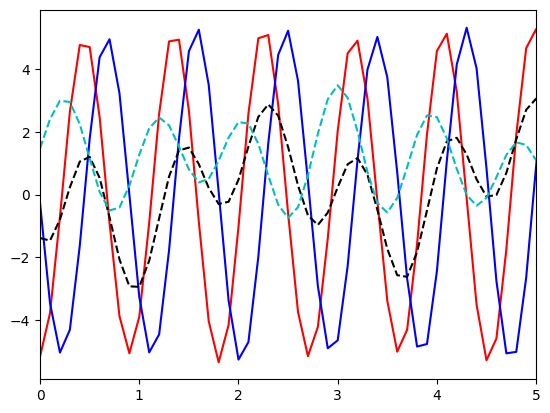

In [159]:
# 4,7
# 5,7
# 0:3,9
# 0:5,11

plot.figure(1)
plot.plot(t,POD_ds[0].dAk_g[:,11],'r')
plot.plot(t,POD_ds[0].dAk_g[:,12],'b')
plot.plot(t,POD_as[5].dAk_g_rot[:,11],'--k')
plot.plot(t,POD_as[5].dAk_g_rot[:,12],'--c')
plot.xlim([0,5])
plot.show()

In [165]:
# error percent plot
if True:
    fig = plot.figure(figsize=(7,4.25))
    plot.subplots_adjust(left=0.08,top=0.97,right=0.99,bottom=0.08)
    outer = gridspec.GridSpec(2,3,wspace=0.25,hspace=0.15)
    subplots = []
    
   
    error_x_tick_labels = ['40','20','10','5','2.5','1.25']
    error_y_ticks = [1E-3,1E-2,1E-1,1,10,]
    error_y_tick_labels = ['1E-3','0.01','0.1','1','10',]
    subplot_labels = ['(a)','(b)','(c)','(d)','(e)','(f)']

    mode_vec = [0,2,4,6,8,10]
    for m_i in range(len(mode_vec)):
        ax = plot.Subplot(fig,outer[m_i])
        subplots.append(ax)
        # note that the first mode is the mean field, so we look at modes i+1 and i+2 for the error plots
        mean_plt,=ax.plot(pts_per_d,0.5*(err_dAk_arr_ds[0,:,mode_vec[m_i]+1]+err_dAk_arr_ds[0,:,mode_vec[m_i]+2]),linewidth=0,marker='o',color='blue',markersize=3,markerfacecolor='blue')
        mean_plt2,=ax.plot(pts_per_d,0.5*(err_dAk_arr_as[0,:,mode_vec[m_i]+1]+err_dAk_arr_as[0,:,mode_vec[m_i]+2]),linewidth=0,marker='o',color='red',markersize=3,markerfacecolor='red')

        ax.set_xscale('log')
        ax.set_xticks(pts_per_d)
        ax.set_yscale('log')
        ax.text(1.5,5,subplot_labels[m_i],fontsize=8,color='k')
        #ax.set_ylim(1E-4,1E0)
        ax.set_yticks(error_y_ticks)
        ax.set_yticklabels(error_y_tick_labels,fontsize=8)
        
        ax.text(5,0.5,'Mode '+str(mode_vec[m_i]+1)+' and '+str(mode_vec[m_i]+2),fontsize=8)

        
        ax.grid('on')
        ax.set_xticks(pts_per_d)
        ax.set_xticklabels(error_x_tick_labels,fontsize=8)
        
        fig.add_subplot(ax)


    subplots[0].set_ylabel("RMS Error ($\eta$)",fontsize=8)
    subplots[0].legend([mean_plt,mean_plt2],['Downsampled','PINN Assimilated',],fontsize=8,ncol=1)
    subplots[3].set_ylabel("RMS Error ($\eta$)",fontsize=8)
    subplots[3].set_xlabel('$D/\Delta x$',fontsize=8,labelpad=-1)
    subplots[4].set_xlabel('$D/\Delta x$',fontsize=8,labelpad=-1)
    subplots[5].set_xlabel('$D/\Delta x$',fontsize=8,labelpad=-1)
    
    plot.savefig(figures_dir+'mode_derivative_error.pdf')
    plot.savefig(figures_dir+'mode_derivative_error.png',dpi=300)
    plot.close(fig)



In [ ]:


# reshape the data
n_elements = i_C_ds[0].size
n_side = np.int64(np.ceil(np.power(n_elements,0.5)))
matrix_C_ds_ref =np.reshape(np.concatenate((i_C_ds[0],np.zeros((n_side*n_side-n_elements,)))),(n_side,n_side))

MAX_plot_C_ref = np.max(np.abs(matrix_C_ds_ref))

error_C_ds = np.zeros((len(S_star,)))
error_C_as = np.zeros((len(S_star,)))

for iS in range(len(S_star)):

    # reshape the data
    matrix_C_ds =np.reshape(np.concatenate((i_C_ds[iS],np.zeros((n_side*n_side-n_elements,)))),(n_side,n_side))
    matrix_C_as =np.reshape(np.concatenate((i_C_as[iS],np.zeros((n_side*n_side-n_elements,)))),(n_side,n_side))

    coeff_mesh_i,coeff_mesh_j = np.meshgrid(np.arange(n_side),np.arange(n_side))


    fig = plot.figure(figsize=(7,3.5*3))
    plot.subplots_adjust(left=0.06,top=0.97,right=0.97,bottom=0.05)
    outer = gridspec.GridSpec(3,2,wspace=0.1,hspace=0.1)

    
    ax = plot.Subplot(fig,outer[0])
    ax.set_aspect('equal')

    p_plot = ax.pcolor(coeff_mesh_i,coeff_mesh_j,np.abs(matrix_C_ds_ref)/MAX_plot_C_ref,cmap='viridis',norm=matplotlib.colors.LogNorm(vmin=1E-4,vmax=1))
    ticklabs = ax.get_yticklabels()
    ax.xaxis.set_tick_params(labelbottom=False)
    ticklabs = ax.get_xticklabels()
    ax.set_xticklabels(ticklabs, fontsize=8)
    fig.add_subplot(ax)

    ax = plot.Subplot(fig,outer[2])
    ax.set_aspect('equal')

    p_plot = ax.pcolor(coeff_mesh_i,coeff_mesh_j,np.abs(matrix_C_ds)/MAX_plot_C_ref,cmap='viridis',norm=matplotlib.colors.LogNorm(vmin=1E-4,vmax=1))
    ticklabs = ax.get_yticklabels()
    ax.xaxis.set_tick_params(labelbottom=False)
    ticklabs = ax.get_xticklabels()
    ax.set_xticklabels(ticklabs, fontsize=8)
    fig.add_subplot(ax)

    ax = plot.Subplot(fig,outer[3])
    ax.set_aspect('equal')

    p_plot = ax.pcolor(coeff_mesh_i,coeff_mesh_j,np.abs(matrix_C_as)/MAX_plot_C_ref,cmap='viridis',norm=matplotlib.colors.LogNorm(vmin=1E-4,vmax=1))
    ticklabs = ax.get_yticklabels()
    ax.xaxis.set_tick_params(labelbottom=False)
    ticklabs = ax.get_xticklabels()
    ax.set_xticklabels(ticklabs, fontsize=8)
    fig.add_subplot(ax)    

    error_C_ds[iS] = np.mean(np.abs(matrix_C_ds-matrix_C_ds_ref)/MAX_plot_C_ref)
    ax = plot.Subplot(fig,outer[4])
    p_plot = ax.pcolor(coeff_mesh_i,coeff_mesh_j,np.abs(matrix_C_ds-matrix_C_ds_ref)/MAX_plot_C_ref,cmap='viridis',norm=matplotlib.colors.LogNorm(vmin=1E-4,vmax=1))
    ticklabs = ax.get_yticklabels()
    ax.xaxis.set_tick_params(labelbottom=False)
    ticklabs = ax.get_xticklabels()
    ax.set_xticklabels(ticklabs, fontsize=8)
    fig.add_subplot(ax)

    error_C_as[iS] = np.mean(np.abs(matrix_C_as-matrix_C_ds_ref)/MAX_plot_C_ref)
    ax = plot.Subplot(fig,outer[5])
    p_plot = ax.pcolor(coeff_mesh_i,coeff_mesh_j,np.abs(matrix_C_as-matrix_C_ds_ref)/MAX_plot_C_ref,cmap='viridis',norm=matplotlib.colors.LogNorm(vmin=1E-4,vmax=1))
    ticklabs = ax.get_yticklabels()
    ax.xaxis.set_tick_params(labelbottom=False)
    ticklabs = ax.get_xticklabels()
    ax.set_xticklabels(ticklabs, fontsize=8)
    fig.add_subplot(ax)

    plot.savefig(figures_dir+'mode_coeff_error_S'+str(S_star[iS])+'.png',dpi=300)
    plot.close(fig)

if True:
    fig = plot.figure(figsize=(3,3))
    plot.subplots_adjust(left=0.1,top=0.97,right=0.97,bottom=0.1)
    outer = gridspec.GridSpec(1,1,wspace=0.1,hspace=0.1)
    subplots = []
    
   
    error_x_tick_labels = ['40','20','10','5','2.5','1.25']
    error_y_ticks = [1E-4,1E-3,1E-2,1E-1,1,]
    error_y_tick_labels = ['1E-4','1E-3','0.01','0.1','1',]
    subplot_labels = ['(a)','(b)','(c)','(d)','(e)','(f)']

    ax = plot.Subplot(fig,outer[0])
    subplots.append(ax)
    # note that the first mode is the mean field, so we look at modes i+1 and i+2 for the error plots
    mean_plt,=ax.plot(pts_per_d,error_C_ds,linewidth=0,marker='o',color='blue',markersize=3,markerfacecolor='blue')
    mean_plt2,=ax.plot(pts_per_d,error_C_as,linewidth=0,marker='o',color='red',markersize=3,markerfacecolor='red')

    ax.set_xscale('log')
    ax.set_xticks(pts_per_d)
    ax.set_yscale('log')
    #ax.text(1.5,0.5,subplot_labels[m_i],fontsize=8,color='k')
    #ax.set_ylim(1E-4,1E0)
    ax.set_yticks(error_y_ticks)
    ax.set_yticklabels(error_y_tick_labels,fontsize=8)
        
    #ax.text(10,2,'Mode '+str(mode_vec[m_i]+1)+' and '+str(mode_vec[m_i]+2),fontsize=8)

    ax.legend([mean_plt,mean_plt2],['Downsampled','PINN Assimilated',],fontsize=8,ncol=1)
    ax.grid('on')
    ax.set_xticks(pts_per_d)
    ax.set_xticklabels(error_x_tick_labels,fontsize=8)
    ax.set_xlabel('$D/\Delta x$',fontsize=8,labelpad=-1)
    fig.add_subplot(ax)


    subplots[0].set_ylabel("RMS Error ($\eta$)",fontsize=8)

    plot.savefig(figures_dir+'mode_coeff_error.pdf')
    plot.savefig(figures_dir+'mode_coeff_error.png',dpi=300)
    plot.close(fig)

In [ ]:

plot.figure(1)
plot.plot(t,POD_ds[0].Ak[:,1],'r')
plot.plot(t,POD_ds[1].Ak[:,1],'r')
plot.xlim([0,20])
plot.figure(2)
plot.plot(t,POD_ds[0].Ak[:,1]-2*POD_ds[1].Ak[:,1],'r')
plot.show()

In [ ]:

plot.figure(1)
#plot.plot(t,POD_as[0].dAk_g[:,1],'b')
plot.plot(t,POD_ds[0].dAk_g[:,1],'r')
#plot.plot(t,POD_as[0].dAk_g[:,2],'--b')
plot.plot(t,POD_ds[0].dAk_g[:,2],'b')
plot.plot(t,POD_ds[2].dAk_g[:,1],'--r')
plot.plot(t,POD_ds[2].dAk_g[:,2],'--b')
plot.xlim([0,20])
plot.show()

In [ ]:
plot.figure(1)

plot.plot(t,POD_ds[0].dAk_g[:,1],'r')
plot.plot(t,POD_ds[0].dAk_g[:,2],'b')
plot.plot(t,POD_as[1].dAk_g[:,1],'--r')
plot.plot(t,POD_as[1].dAk_g[:,2],'--b')
plot.xlim([0,20])
plot.show()

In [ ]:
plot.figure(1)

plot.plot(t,POD_ds[0].dAk_g[:,3],'r')
plot.plot(t,POD_ds[0].dAk_g[:,4],'b')
plot.plot(t,POD_ds[2].dAk_g[:,3],'--r')
plot.plot(t,POD_ds[2].dAk_g[:,4],'--b')
plot.xlim([0,10])
plot.show()

In [ ]:
plot.figure(1)

plot.plot(t,POD_ds[0].dAk_g[:,3],'r')
plot.plot(t,POD_ds[0].dAk_g[:,4],'b')
plot.plot(t,POD_as[1].dAk_g[:,3],'--r')
plot.plot(t,POD_as[1].dAk_g[:,4],'--b')
plot.xlim([0,20])
plot.show()

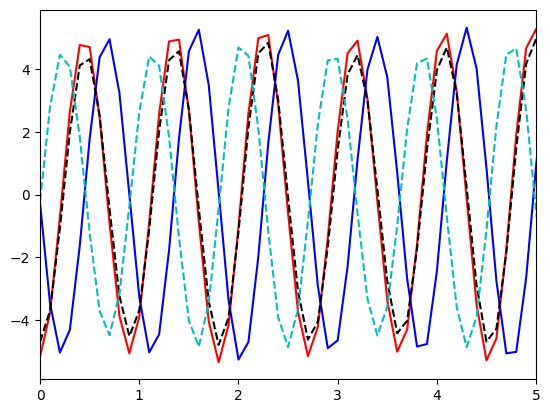

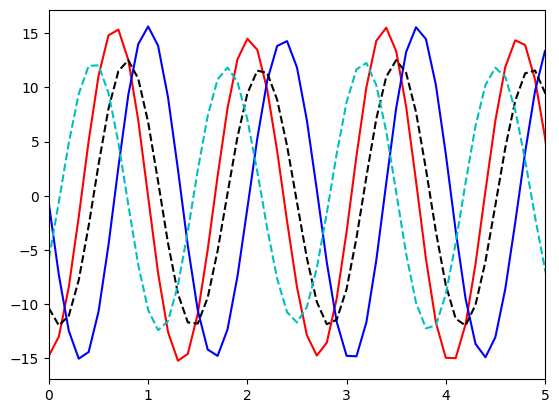

In [ ]:
plot.figure(1)

plot.plot(t,POD_ds[0].dAk_g[:,10],'r')
plot.plot(t,POD_ds[0].dAk_g[:,11],'b')
plot.plot(t,POD_as[2].dAk_g[:,10],'--r')
plot.plot(t,POD_as[2].dAk_g[:,11],'--b')
plot.xlim([0,5])
plot.show()

In [ ]:
plot.figure(1)
plot.plot(t,POD_ds[0].dAk_g[:,5],'r')
plot.plot(t,POD_ds[0].dAk_g[:,6],'--r')
plot.plot(t,POD_ds[3].dAk_g[:,5],'b')
plot.plot(t,POD_ds[3].dAk_g[:,6],'--b')

plot.xlim([0,5])
plot.show()

In [166]:
print(theta_as)
print(theta_m_as)

[[-1.13414294e-02  2.65504442e-02  3.06073627e+00  1.14640895e+00
  -5.78155113e-02  2.30628832e+00]
 [-1.15625589e-02  2.60168932e-02  3.06357642e+00  1.14997033e+00
  -7.05831079e-02  2.32739654e+00]
 [-1.12385085e-02  2.49903028e-02  3.06617986e+00  1.13616250e+00
  -8.02226019e-02  2.32328958e+00]
 [-1.03983701e-02  2.82386422e-02  3.06600783e+00  1.24741939e+00
   4.53751086e-02  5.19163086e-01]
 [ 2.21456132e-03  7.78381067e-02  1.34792054e-01 -3.05412446e+00
  -1.01472275e+00  1.37077786e+00]
 [-4.47480134e-02  9.24558326e-01  2.54688329e+00 -3.08408901e+00
   1.86050925e+00  2.06725499e+00]]
[[ 1.57079633  1.57079633  1.57079633  1.57079633 -1.57079633 -1.57079633]
 [ 1.57079633  1.57079633  1.57079633  1.57079633 -1.57079633 -1.57079633]
 [ 1.57079633  1.57079633  1.57079633  1.57079633 -1.57079633 -1.57079633]
 [ 1.57079633  1.57079633  1.57079633  1.57079633 -1.57079633 -1.57079633]
 [ 1.57079633  1.57079633  1.57079633 -1.57079633  1.57079633 -1.57079633]
 [ 1.57079633  1.5